<a href="https://colab.research.google.com/github/aryan-at-ul/graph_neural_networks_basics/blob/main/LBP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<ipython-input-8-a8a0120434c1>:12: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_image = pil_image.resize((100, 100), Image.ANTIALIAS)


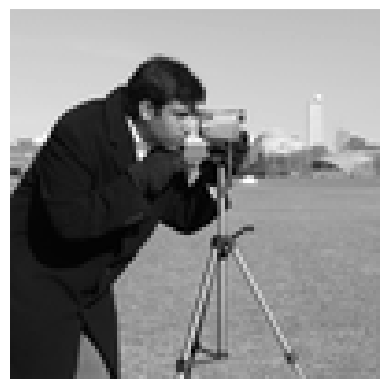

In [8]:
from skimage import data
from PIL import Image
import numpy as np

# Load the camera image
image = data.camera()

# Convert to PIL image for easy resizing
pil_image = Image.fromarray(image)

# Resize the image to 64x64 pixels
resized_image = pil_image.resize((100, 100), Image.ANTIALIAS)

# Convert back to numpy array if needed
resized_image_np = np.array(resized_image)

# If you need to display the image, you can use matplotlib
import matplotlib.pyplot as plt

plt.imshow(resized_image_np, cmap='gray')
plt.axis('off')
plt.show()

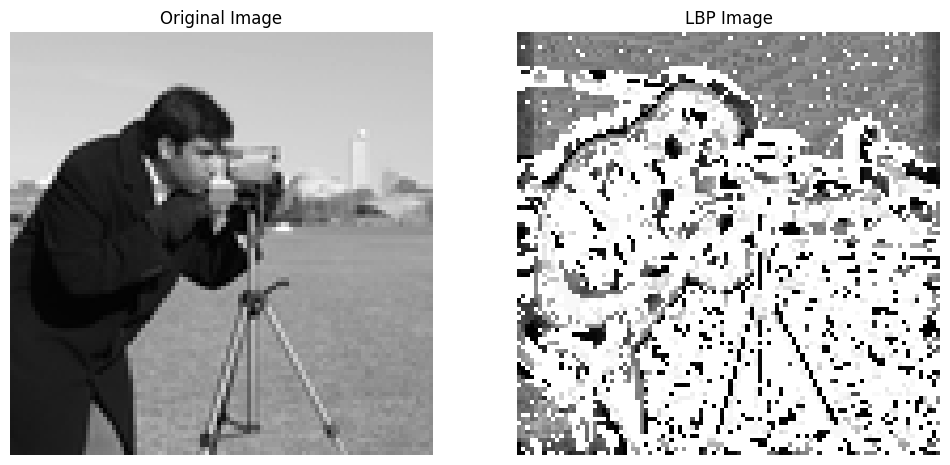

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, feature, color
from skimage.future import graph
from skimage.segmentation import slic

# Load the sample image
image = resized_image_np#data.camera()

# Apply Local Binary Patterns
radius = 4
n_points = 8 * radius
lbp = feature.local_binary_pattern(image, n_points, radius, method="uniform")

# Display the original image and the LBP image
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(image, cmap='gray')
ax[0].set_title('Original Image')
ax[0].axis('off')

ax[1].imshow(lbp, cmap='gray')
ax[1].set_title('LBP Image')
ax[1].axis('off')

plt.show()



In [18]:

from skimage import img_as_ubyte
import networkx as nx

# Apply Local Binary Patterns on the image
lbp_image = feature.local_binary_pattern(image, n_points, radius, method="uniform")


# Normalize the LBP image to the range [0, 1]
lbp_min, lbp_max = lbp_image.min(), lbp_image.max()
lbp_image_normalized = (lbp_image - lbp_min) / (lbp_max - lbp_min)

# Convert the normalized LBP image to 8-bit
lbp_image_ubyte = img_as_ubyte(lbp_image_normalized)

print(lbp_image_ubyte.shape)

# Using a subsample for visualization purposes
subsample_size = 100
subsampled_image = lbp_image_ubyte[:subsample_size, :subsample_size]
subsampled_graph = nx.grid_2d_graph(subsample_size, subsample_size)

# Display the subsampled LBP image and the graph
# fig, ax = plt.subplots(1, 2, figsize=(12, 6))
# ax[0].imshow(subsampled_image, cmap='gray')
# ax[0].set_title('Subsampled LBP Image')
# ax[0].axis('off')

# # Draw the graph on the LBP image
# ax[1].imshow(subsampled_image, cmap='gray')
# ax[1].set_title('Graph on Subsampled LBP Image')
# for ((x0, y0), (x1, y1)) in subsampled_graph.edges:
#     ax[1].plot([y0, y1], [x0, x1], color='cyan')

# ax[1].axis('off')
# plt.show()



(100, 100)


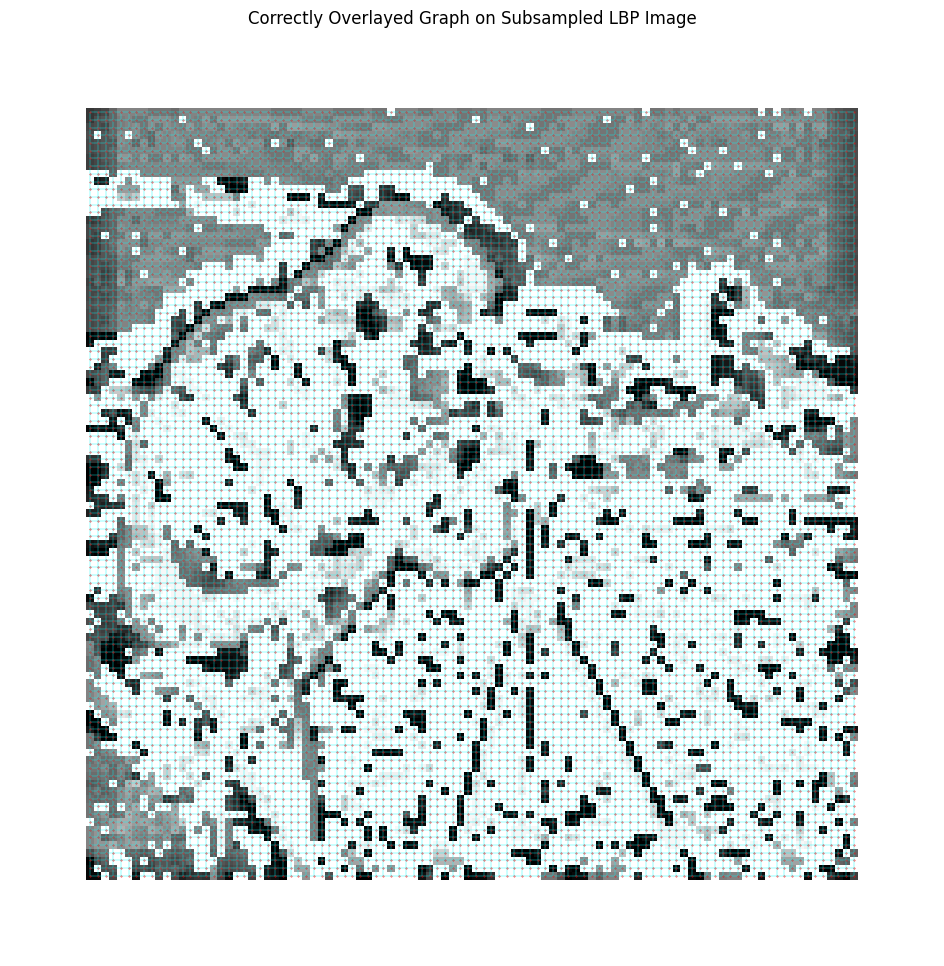

In [23]:
# Adjust the positions of the nodes to match the image's coordinate system
# In the image, (0,0) is at the top-left corner, and y increases downwards.
pos = {(x, y): (y, x) for x, y in subsampled_graph.nodes()}

# Draw the graph using NetworkX's drawing function with adjusted positions
fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(subsampled_image, cmap='gray')
nx.draw(subsampled_graph, pos=pos, ax=ax, node_size=0.1,node_color = 'red', edge_color='cyan', width=0.3)
ax.set_title('Correctly Overlayed Graph on Subsampled LBP Image')
ax.axis('off')

plt.show()



<ipython-input-24-0d0a89c723bb>:18: RuntimeWarning: overflow encountered in ubyte_scalars
  if neighbor not in visited and abs(graph.nodes[neighbor]['value'] - graph.nodes[node]['value']) < 1:


6249
6249
6249
6249
6249


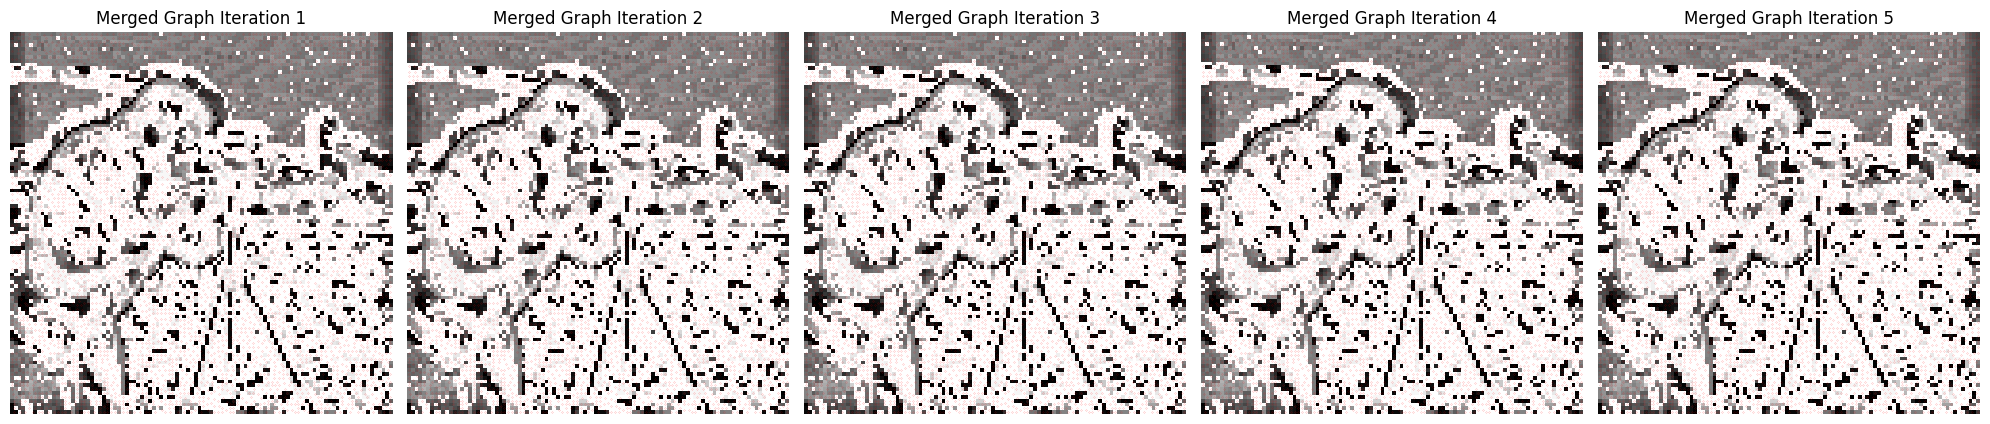

In [24]:
def merge_nodes_correctly(graph):
    # New graph to store merged nodes
    new_graph = nx.Graph()

    # Set to keep track of visited (merged) nodes
    visited = set()

    for node in graph.nodes:
        if node not in visited:
            # Neighbors of the current node
            neighbors = list(nx.neighbors(graph, node))
            merge_positions = [np.array(node)]
            merge_values = [graph.nodes[node]['value']]
            visited.add(node)

            # Check neighbors for potential merging
            for neighbor in neighbors:
                if neighbor not in visited and abs(graph.nodes[neighbor]['value'] - graph.nodes[node]['value']) < 1:
                    merge_positions.append(np.array(neighbor))
                    merge_values.append(graph.nodes[neighbor]['value'])
                    visited.add(neighbor)

            # Compute the new node's position (centroid) and value (average)
            centroid = tuple(np.mean(merge_positions, axis=0))
            avg_value = np.mean(merge_values)

            # Add the new node to the graph
            new_graph.add_node(centroid, value=avg_value)

    return new_graph

# Apply the merging operation and plot the graph five times
fig, axes = plt.subplots(1, 5, figsize=(20, 8))

# Re-create the original subsampled graph and assign pixel values as node features
subsampled_graph = nx.grid_2d_graph(subsample_size, subsample_size)
for x in range(subsample_size):
    for y in range(subsample_size):
        subsampled_graph.nodes[(x, y)]['value'] = subsampled_image[x, y]

for i in range(5):
    # Merge nodes
    subsampled_graph = merge_nodes_correctly(subsampled_graph)

    # Update positions of the nodes in the graph
    pos = {node: node for node in subsampled_graph.nodes()}
    print(len(subsampled_graph.nodes()))
    # Draw the graph on the LBP image
    axes[i].imshow(subsampled_image, cmap='gray')
    nx.draw(subsampled_graph, pos=pos, ax=axes[i], node_size=0.01,node_color = 'red', edge_color='cyan', width=0.01)
    axes[i].set_title(f'Merged Graph Iteration {i+1}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()



Iteration 0, Merging 8825 nodes
Iteration 1, Merging 353 nodes
Iteration 2, Merging 0 nodes


<ipython-input-59-a092d042d263>:44: RuntimeWarning: overflow encountered in ubyte_scalars
  value_diff = abs(values[idx] - values[neighbor_idx])


Iteration 0, Merging 4618 nodes
Iteration 1, Merging 0 nodes


<ipython-input-59-a092d042d263>:44: RuntimeWarning: overflow encountered in ubyte_scalars
  value_diff = abs(values[idx] - values[neighbor_idx])


Iteration 0, Merging 1279 nodes
Iteration 1, Merging 0 nodes
Iteration 0, Merging 354 nodes
Iteration 1, Merging 0 nodes
Iteration 0, Merging 94 nodes
Iteration 1, Merging 0 nodes


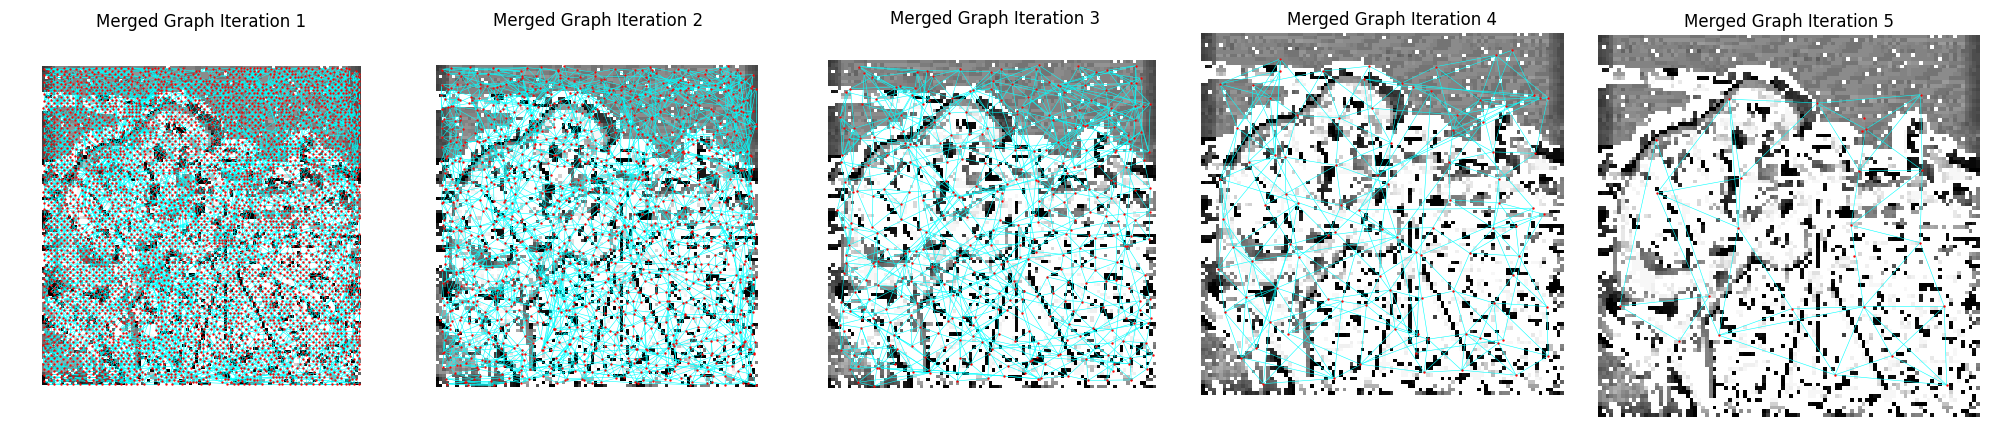

[4750, 1333, 363, 96, 25]

In [59]:
import networkx as nx
import numpy as np

def is_close_to_any_position(position, positions):
    """Check if a position is close to any position in a list of positions."""
    return any(np.allclose(position, pos) for pos in positions)



from sklearn.neighbors import NearestNeighbors

# def apply_knn_and_add_edges(graph, k=5, value_diff_threshold=50):
#     # Extract nodes and their values
#     nodes, values = zip(*[(node, data['value']) for node, data in graph.nodes(data=True)])
#     values_array = np.array(values).reshape(-1, 1)
#     # print(values_array)
#     # Apply KNN
#     nbrs = NearestNeighbors(n_neighbors=k, algorithm='auto').fit(values_array)
#     distances, indices = nbrs.kneighbors(values_array)

#     # Add edges based on KNN results
#     for idx, neighbors in enumerate(indices):
#         for neighbor_idx in neighbors[1:]:  # Skip the first neighbor (node itself)
#             if abs(values[idx] - values[neighbor_idx]) < value_diff_threshold:
#                 graph.add_edge(nodes[idx], nodes[neighbor_idx])


value_diff_threshold = 50
spatial_dist_threshold = 50
def apply_knn_and_add_edges(graph, k=5, value_diff_threshold=value_diff_threshold, spatial_dist_threshold=spatial_dist_threshold):
    # Extract nodes, their values, and positions
    nodes, positions, values = zip(*[(node, node, data['value']) for node, data in graph.nodes(data=True)])

    # Combine values and positions into a single array
    combined_features = np.array([(pos[0], pos[1], val) for pos, val in zip(positions, values)])

    # Apply KNN
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='auto').fit(combined_features)
    distances, indices = nbrs.kneighbors(combined_features)

    # Add edges based on KNN results
    for idx, neighbors in enumerate(indices):
        for neighbor_idx in neighbors[1:]:  # Skip the first neighbor (node itself)
            value_diff = abs(values[idx] - values[neighbor_idx])
            spatial_dist = np.linalg.norm(np.array(positions[idx]) - np.array(positions[neighbor_idx]))

            if value_diff < value_diff_threshold and spatial_dist < spatial_dist_threshold:
                graph.add_edge(nodes[idx], nodes[neighbor_idx])



def merge_nodes_correctly(graph):
    merged = True
    iteration = 0
    while merged:
        merged = False
        to_remove = set()
        new_nodes = []

        current_nodes = list(graph.nodes())  # Work on a snapshot of current nodes

        for node in current_nodes:
            if node in to_remove:
                continue

            node_tuple = tuple(node) if isinstance(node, np.ndarray) else node
            neighbors = set(nx.neighbors(graph, node_tuple))
            merge_positions = [node_tuple]
            merge_values = [graph.nodes[node_tuple]['value']]

            # Check if any neighbor can be merged
            for neighbor in neighbors:
                neighbor_tuple = tuple(neighbor) if isinstance(neighbor, np.ndarray) else neighbor
                # if neighbor_tuple not in to_remove and abs(graph.nodes[neighbor_tuple]['value'] - graph.nodes[node_tuple]['value']) < 1:
                if neighbor_tuple not in to_remove and abs(int(graph.nodes[neighbor_tuple]['value']) - int(graph.nodes[node_tuple]['value'])) < value_diff_threshold:

                    merge_positions.append(neighbor_tuple)
                    merge_values.append(graph.nodes[neighbor_tuple]['value'])
                    to_remove.add(neighbor_tuple)

            # Merge nodes if there are eligible neighbors
            if len(merge_positions) > 1:
                centroid = tuple(np.mean([np.array(pos) for pos in merge_positions], axis=0))
                avg_value = np.mean(merge_values)
                new_node = centroid
                new_nodes.append((new_node, avg_value))
                to_remove.update(merge_positions)  # Add all merged positions to removal list
                merged = True

        print(f"Iteration {iteration}, Merging {len(to_remove)} nodes")
        iteration += 1

        # Remove old nodes and add new nodes
        graph.remove_nodes_from(to_remove)
        for new_node, value in new_nodes:
            graph.add_node(new_node, value=value)
            all_neighbors = set()
            for old_node in merge_positions:
                old_node_tuple = tuple(old_node) if isinstance(old_node, np.ndarray) else old_node
                if old_node_tuple in graph:
                    all_neighbors.update(nx.neighbors(graph, old_node_tuple))
            all_neighbors.difference_update(to_remove)
            for neighbor in all_neighbors:
                graph.add_edge(new_node, neighbor)

    return graph

# Apply the merging operation and plot the graph five times
fig, axes = plt.subplots(1, 5, figsize=(20, 8))

# Re-create the original subsampled graph and assign pixel values as node features
subsampled_graph = nx.grid_2d_graph(subsample_size, subsample_size)
for x in range(subsample_size):
    for y in range(subsample_size):
        subsampled_graph.nodes[(x, y)]['value'] = subsampled_image[x, y]

node_counts = []

for i in range(5):
    # Merge nodes
    subsampled_graph = merge_nodes_correctly(subsampled_graph)

    # Apply KNN and add edges
    # if i != 1:
    apply_knn_and_add_edges(subsampled_graph)

    # Count the number of nodes after merging
    node_counts.append(len(subsampled_graph.nodes()))

    # Update positions of the nodes in the graph
    pos = {node: node for node in subsampled_graph.nodes()}

    # Draw the graph on the LBP image
    axes[i].imshow(subsampled_image, cmap='gray')
    nx.draw(subsampled_graph, pos=pos, ax=axes[i], node_size=0.5,node_color = 'red', edge_color='cyan', width=0.4)
    axes[i].set_title(f'Merged Graph Iteration {i+1}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

node_counts

